In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

In [69]:
# -- NEW ANALYZE FACES NOTEBOOK --
# 1. Detect valid frames (frames where we have searched faces)
#    Center frame the 80s is the frame where action t=0
# 2. Assign frames to an action
# 3. Create interesting dataframes as the following ones

In [70]:
detections_path_1 = Path('../../../../mnt/DATA/datasets/soccernet/germany_bundesliga/2014-2015/2015-05-02 - 16-30 Hoffenheim 1 - 1 Dortmund/face_detection_results_1_HQ.npy')
detections_path_2 = Path('../../../../mnt/DATA/datasets/soccernet/germany_bundesliga/2014-2015/2015-05-02 - 16-30 Hoffenheim 1 - 1 Dortmund/face_detection_results_2_HQ.npy')
detections1 = np.load(detections_path_1, allow_pickle=True)[0]
detections2 = np.load(detections_path_2, allow_pickle=True)[0]


In [98]:
count1=0
for frame_id in detections1.keys():
    if len(detections1[frame_id]) > 0:
        count1 += len(detections1[frame_id])
        
count2=0
for frame_id in detections2.keys():
    if len(detections2[frame_id]) > 0:
        count2 += len(detections2[frame_id])

In [101]:
count1 + count2

96216

In [71]:
from pathlib import Path
import json
import cv2

json_path = detections_path_1.parent.joinpath('Labels-v2.json')
with open(json_path) as f:
    data = json.load(f)
annotations = data['annotations']
for i in range(0, len(annotations)):
    if annotations[i]['gameTime'][0] == '2':
        index = i
        break
an1 = annotations[:index]
an2 = annotations[index:]
actions = [an1, an2]

In [72]:
def first_last_frame(frame_num, seconds_window, fs, num_frames):
    first = max(frame_num - (seconds_window * fs), 1)
    last = min(num_frames, frame_num + (seconds_window * fs))
    return first, last

def get_frame(position, fs):
    return (position // 1000) * fs

def get_valid_frames_df(half, detections_path):
    frames_dir = detections_path.parent.joinpath(f'{half+1}_HQ','frames')
    seconds_window = 10
    fs = 8
    num_frames = len(list(frames_dir.glob('*.jpg')))

    valid_frames = set()
    for action in actions[half]:
        position = int(action['position'])
        frame_num = get_frame(position, fs)
        first_action_frame, last_action_frame = first_last_frame(frame_num, seconds_window, fs, num_frames)
        for frame_id in range(first_action_frame, last_action_frame+1):
            valid_frames.add((f'{frame_id:05}', action['label'], first_action_frame, last_action_frame, int((first_action_frame+last_action_frame)/2)))

    invalid_frames = list(set(np.arange(num_frames)) - valid_frames)
    valid_frames = sorted(valid_frames)
    valid_frames_df = pd.DataFrame(valid_frames, columns=['frame','label','first','last','center'])
    
    return (valid_frames_df, valid_frames)
    
def get_faces_list_df(vf, detections):
    faces_list_df = pd.DataFrame(columns=['frame','face_id','info'])
    count = 0
    for key in vf:
        if len(detections[key[0]])>0:
            for face in detections[key[0]]:
                count += 1
                line = pd.DataFrame({'frame':[key[0]], 'face_id':[face], 'info':[detections[key[0]][face]['score']]})
                faces_list_df = pd.concat([faces_list_df, line], axis=0)
    print(count)
    return faces_list_df

In [73]:
# 1st Half
valid_frames_df_1, valid_frames_1 = get_valid_frames_df(0, detections_path_1)
faces_list_df_1 = get_faces_list_df(valid_frames_1.copy(), detections1).drop_duplicates()
faces_info_df_1 = pd.merge(faces_list_df_1, valid_frames_df_1, on=['frame'], how='inner')


78634


In [75]:
faces_diff_1 = faces_info_df_1.copy()
faces_diff_1['relative_frame'] = faces_diff_1['frame'].astype(int) - faces_diff_1['center']


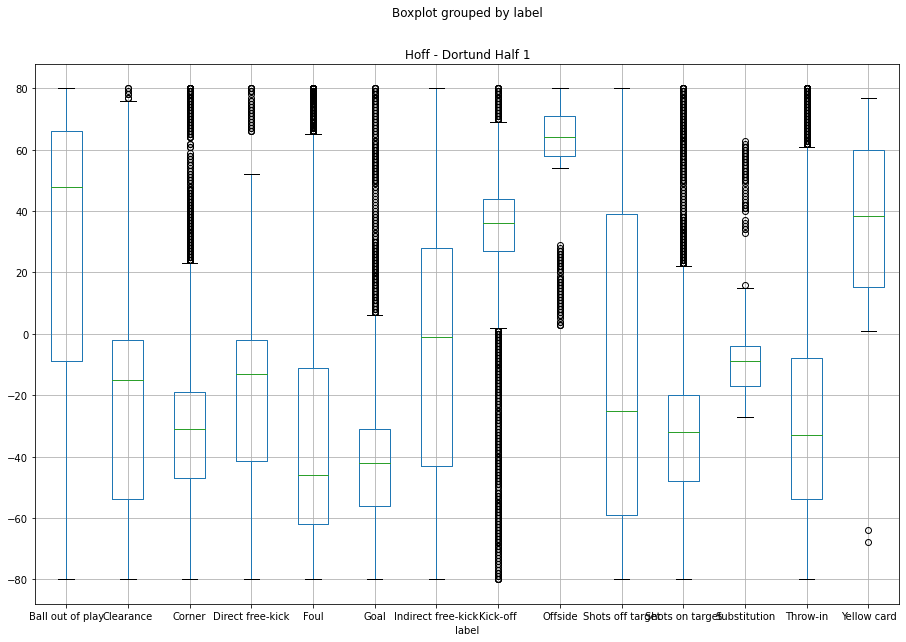

In [76]:
faces_diff_1.boxplot(column='relative_frame',by='label', figsize=(15,10))
plt.title('Hoff - Dortund Half 1')
plt.show()



63798


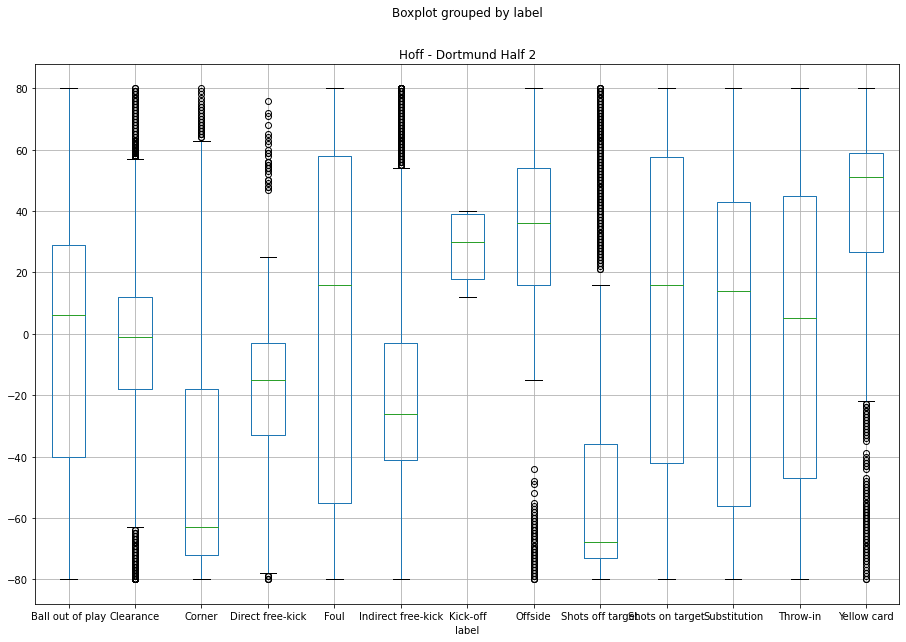

In [77]:
# 2nd Half
valid_frames_df_2, valid_frames_2 = get_valid_frames_df(1, detections_path_2)
faces_list_df_2 = get_faces_list_df(valid_frames_2, detections2).drop_duplicates()
faces_info_df_2 = pd.merge(faces_list_df_2, valid_frames_df_2, on=['frame'], how='inner')

faces_diff_2 = faces_info_df_2.copy()
faces_diff_2['relative_frame'] = faces_diff_2['frame'].astype(int) - faces_diff_2['center']

faces_diff_2.boxplot(column='relative_frame',by='label', figsize=(15,10))
plt.title('Hoff - Dortmund Half 2')
plt.show()


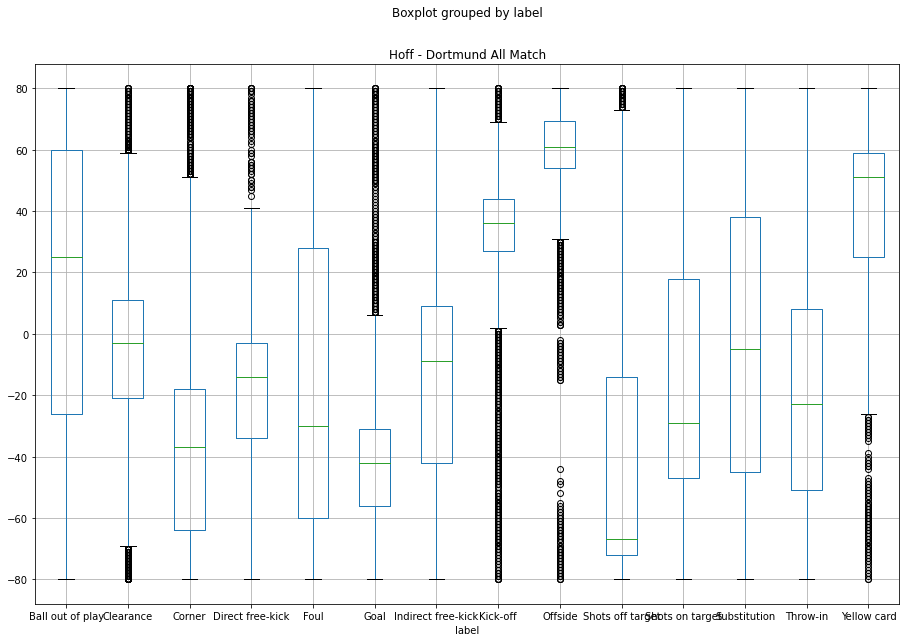

In [78]:
# All Match
faces_diff_1['half'] = 1
faces_diff_2['half'] = 2
faces_diff_all = pd.concat([faces_diff_1, faces_diff_2]).reset_index(drop=True)
faces_diff_all.boxplot(column='relative_frame',by='label', figsize=(15,10))
plt.title('Hoff - Dortmund All Match')
plt.show()

In [90]:
faces_diff_all[['frame','face_id','half']].drop_duplicates()


,frame,face_id,half
0,00104,face_1,1
2,00105,face_1,1
4,00106,face_1,1
6,00107,face_1,1
8,00108,face_1,1
...,...,...,...
142427,22229,face_1,2
142428,22232,face_1,2
142429,22233,face_1,2
142430,22234,face_1,2


In [45]:
# -- Example of EXTRACTED INFORMATION VECTOR -- 

In [114]:
extractions_path_1 = Path('../../../../mnt/DATA/datasets/soccernet/germany_bundesliga/2014-2015/2015-05-02 - 16-30 Hoffenheim 1 - 1 Dortmund/face_extraction_results.npy')
extractions = np.load(extractions_path_1, allow_pickle=True)


In [117]:
extractions[0]

array([(0, '00105', 0, 9657),
       array([0.        , 0.73177147, 0.        , 0.        , 0.        ,
              0.        , 0.47095755, 0.        , 0.        , 0.        ,
              0.01852085, 0.        , 0.        , 0.        , 0.        ,
              0.14354783, 0.        , 0.61414003, 0.        , 0.        ,
              0.        , 0.        , 0.30928504, 0.        , 0.        ,
              0.        , 0.        , 0.        , 0.        , 0.        ,
              0.3074405 , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.11440554, 0.04329154, 0.04583853, 0.        ,
              0.10329179, 0.        , 0.        , 0.08274055, 0.        ,
              0.        , 0.11122925, 0.        , 0.        , 0.        ,
              0.0051738 , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.02507813, 0.        , 0.        , 0.        ,
              0.00216934, 0.        , 0.        , 0.        , 0.        ,
        